# 导入必要库

In [1]:
from pathlib import Path
import gc


from core import RLEnv
from core.agent import BaseAgent
from greedy import (
    EpsilonDecreasingConfig,
    GreedyAgent,
    greedy_average,
    epsilon_average,
    epsilon_decreasing_average,
)
from ucb1 import UCBAgent, ucb1

In [2]:
STEPS: int = 100
LOG_INTERVAL: int = 1

SEED: int = 42
MACHINE_COUNT: int = 10
COUNT: int = 50
CONVERGENCE_THRESHOLD: float = 0.9
CONVERGENCE_MIN_STEPS: int = 1000
OPTIMISTIC_TIMES: int = 1
ENABLE_OPTIMISTIC: bool = True
EXPERIMENT_DATA_DIR: Path = Path.cwd() / "experiment_data"

ENV: RLEnv = RLEnv(machine_count=MACHINE_COUNT, seed=SEED)
EPSILON_CONFIG: EpsilonDecreasingConfig = EpsilonDecreasingConfig()

In [3]:
from train import batch_train
from utils import plot_metrics_history, save_experiment_data

# Agent 创建函数

In [4]:
def create_greedy_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=greedy_average.__name__,
        env=env,
        greedy_algorithm=greedy_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

def create_epsilon_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_average.__name__,
        env=env,
        greedy_algorithm=epsilon_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

def create_decreasing_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_decreasing_average.__name__,
        env=env,
        greedy_algorithm=epsilon_decreasing_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

In [5]:
def create_ucb1_agent(
    env: RLEnv,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return UCBAgent(
        name=ucb1.__name__,
        env=env,
        ucb1_algorithm=ucb1,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

# 训练

## 普通贪婪算法

avg_regret=3.958181818181813 avg_regret_rate=0.04837777777777772 avg_total_reward=77.86 avg_optimal_rate=0.5164444444444447 avg_convergence_steps=0.0 avg_convergence_rate=0.0
values=[0.14, 0.26, 0.5, 0.78, 1.16, 3.0, 3.4, 12.68, 13.78, 42.16] counts=[1.14, 1.26, 1.54, 1.84, 2.44, 5.48, 5.24, 17.56, 17.02, 46.48]


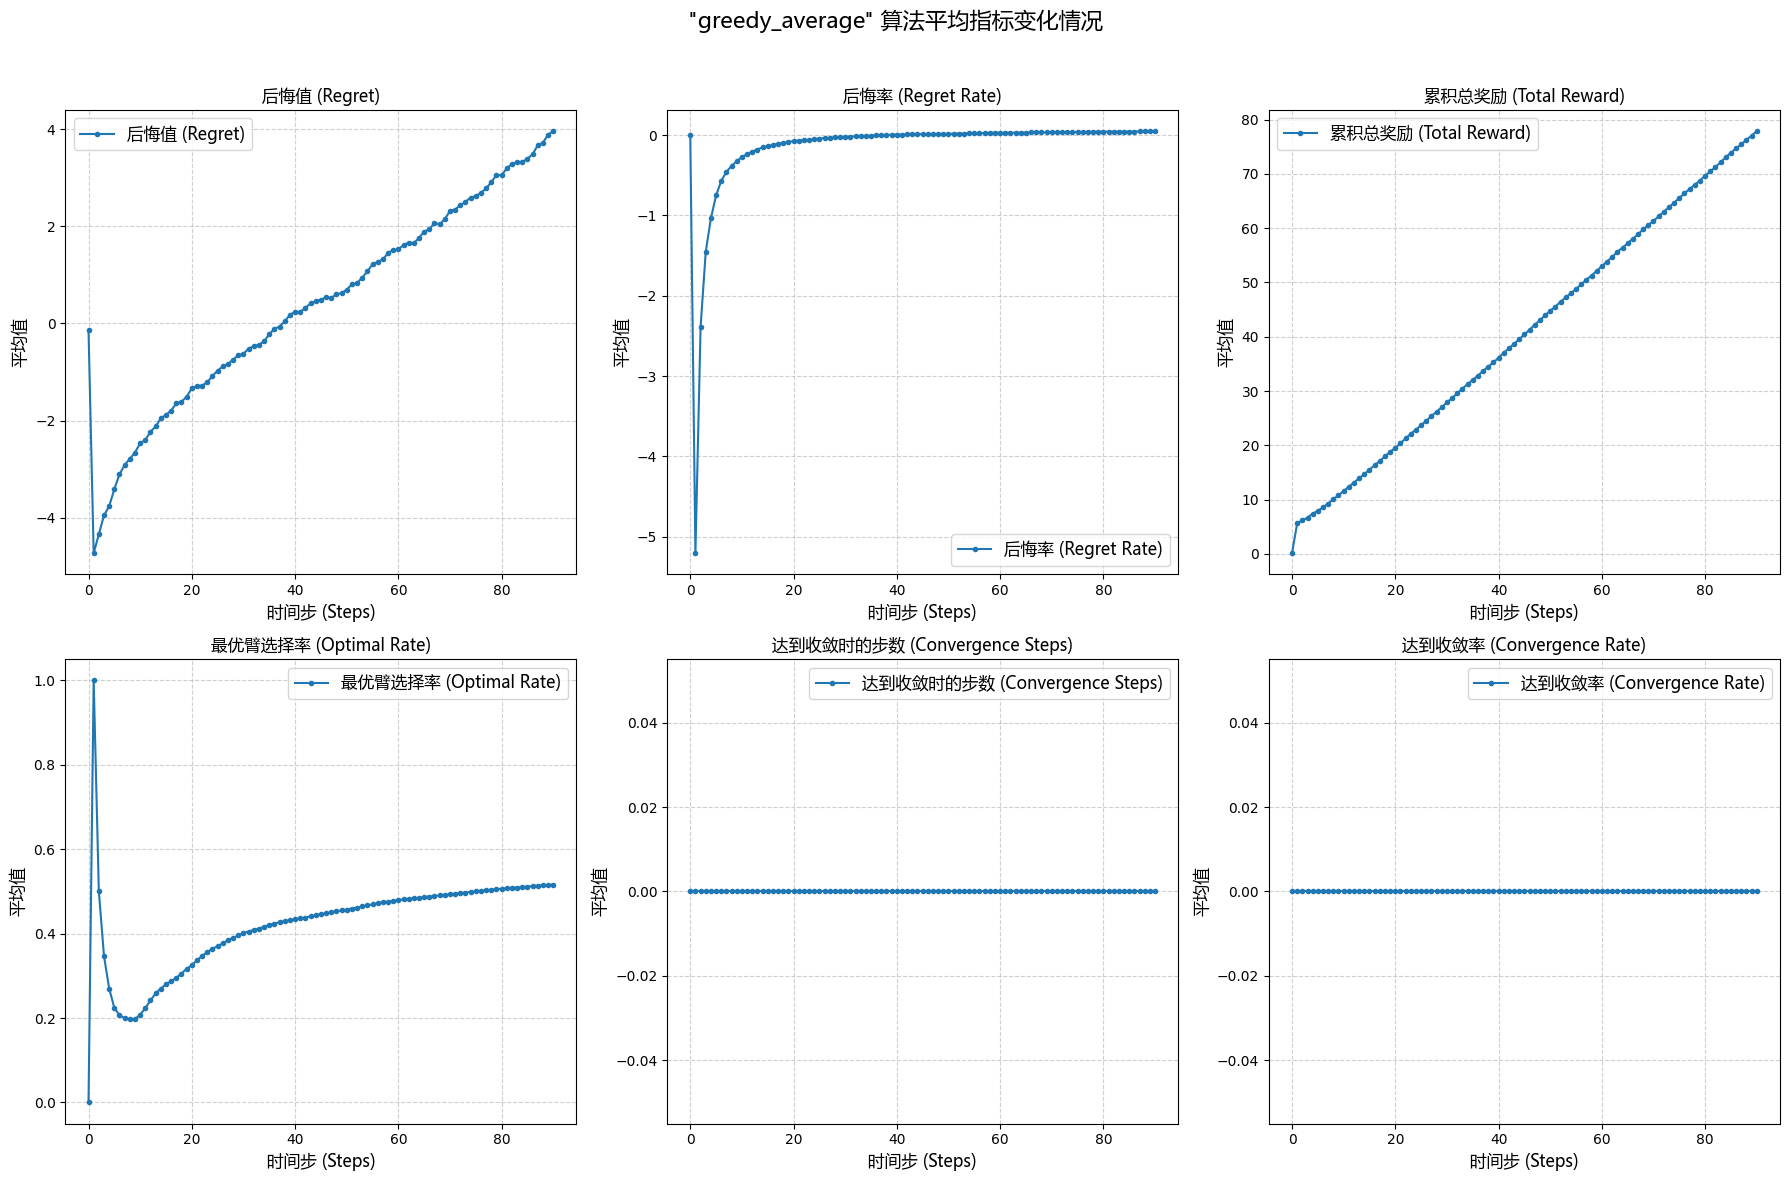

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average_T=100_K=10_Q_0=1.png
✅ 实验数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average_T=100_K=10_Q_0=1.json


21285

In [6]:
agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_greedy_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    log_steps=LOG_INTERVAL,
)
print(metrics)
print(reward)

file_name: Path =EXPERIMENT_DATA_DIR / f"{greedy_average.__name__}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
plot_metrics_history(agents, greedy_average.__name__, file_name)
save_experiment_data(reward, metrics, file_name)

del agents, reward, metrics
gc.collect()

## epsilon-贪婪算法

avg_regret=5.138181818181813 avg_regret_rate=0.06279999999999994 avg_total_reward=76.68 avg_optimal_rate=0.49933333333333324 avg_convergence_steps=0.0 avg_convergence_rate=0.0
values=[0.18, 0.36, 0.8, 0.92, 1.36, 1.54, 3.78, 9.8, 16.8, 41.14] counts=[1.84, 2.1, 2.48, 2.62, 2.9, 2.92, 6.18, 13.56, 20.46, 44.94]


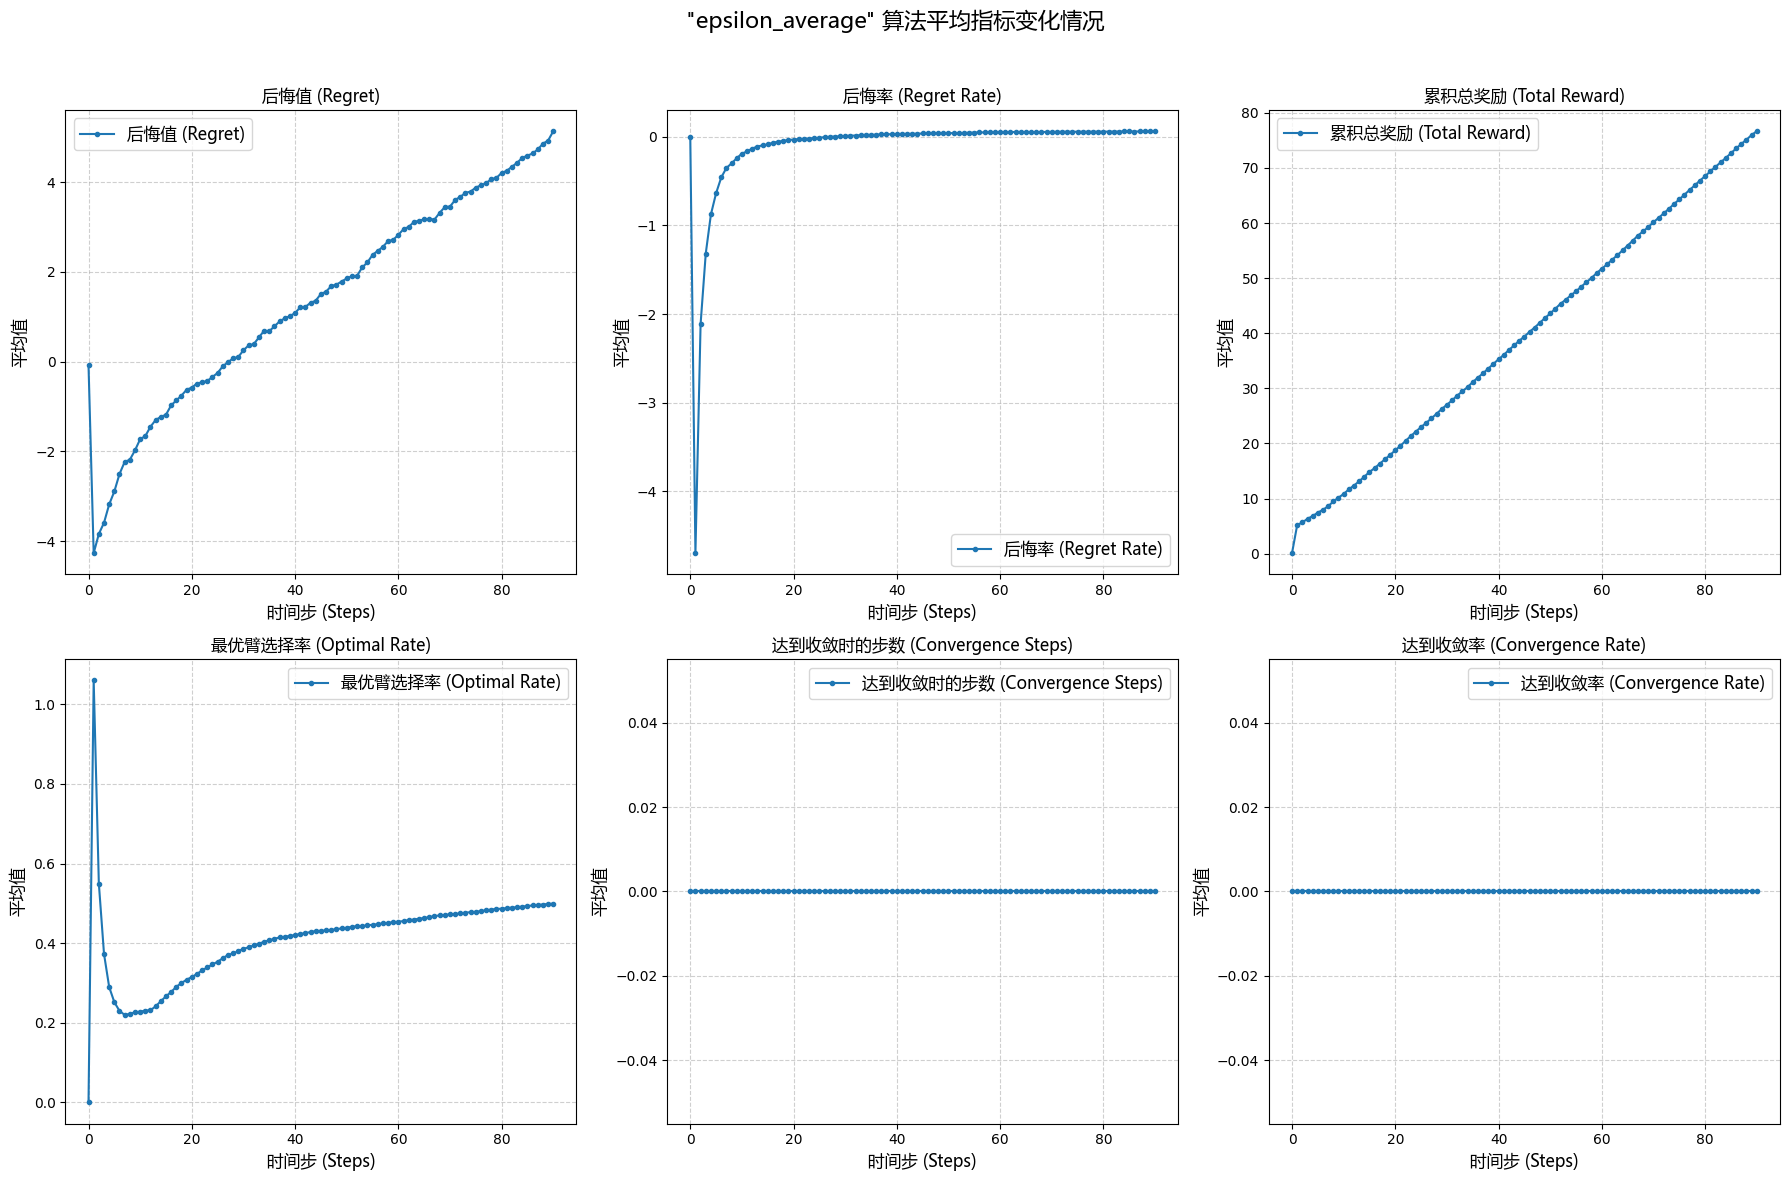

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_average_T=100_K=10_Q_0=1.png
✅ 实验数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_average_T=100_K=10_Q_0=1.json


21095

In [7]:
agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_epsilon_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    log_steps=LOG_INTERVAL,
)
print(metrics)
print(reward)

file_name: Path =EXPERIMENT_DATA_DIR / f"{epsilon_average.__name__}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
plot_metrics_history(agents, epsilon_average.__name__, file_name)
save_experiment_data(reward, metrics, file_name)

del agents, reward, metrics
gc.collect()

## 退火 epsilon 贪婪算法

avg_regret=26.83818181818178 avg_regret_rate=0.3280222222222221 avg_total_reward=54.98 avg_optimal_rate=0.1804444444444444 avg_convergence_steps=0.0 avg_convergence_rate=0.0
values=[0.68, 1.46, 2.38, 3.22, 3.44, 4.52, 5.36, 7.58, 11.52, 14.82] counts=[8.42, 8.94, 8.48, 8.76, 7.66, 8.54, 8.82, 10.4, 13.74, 16.24]


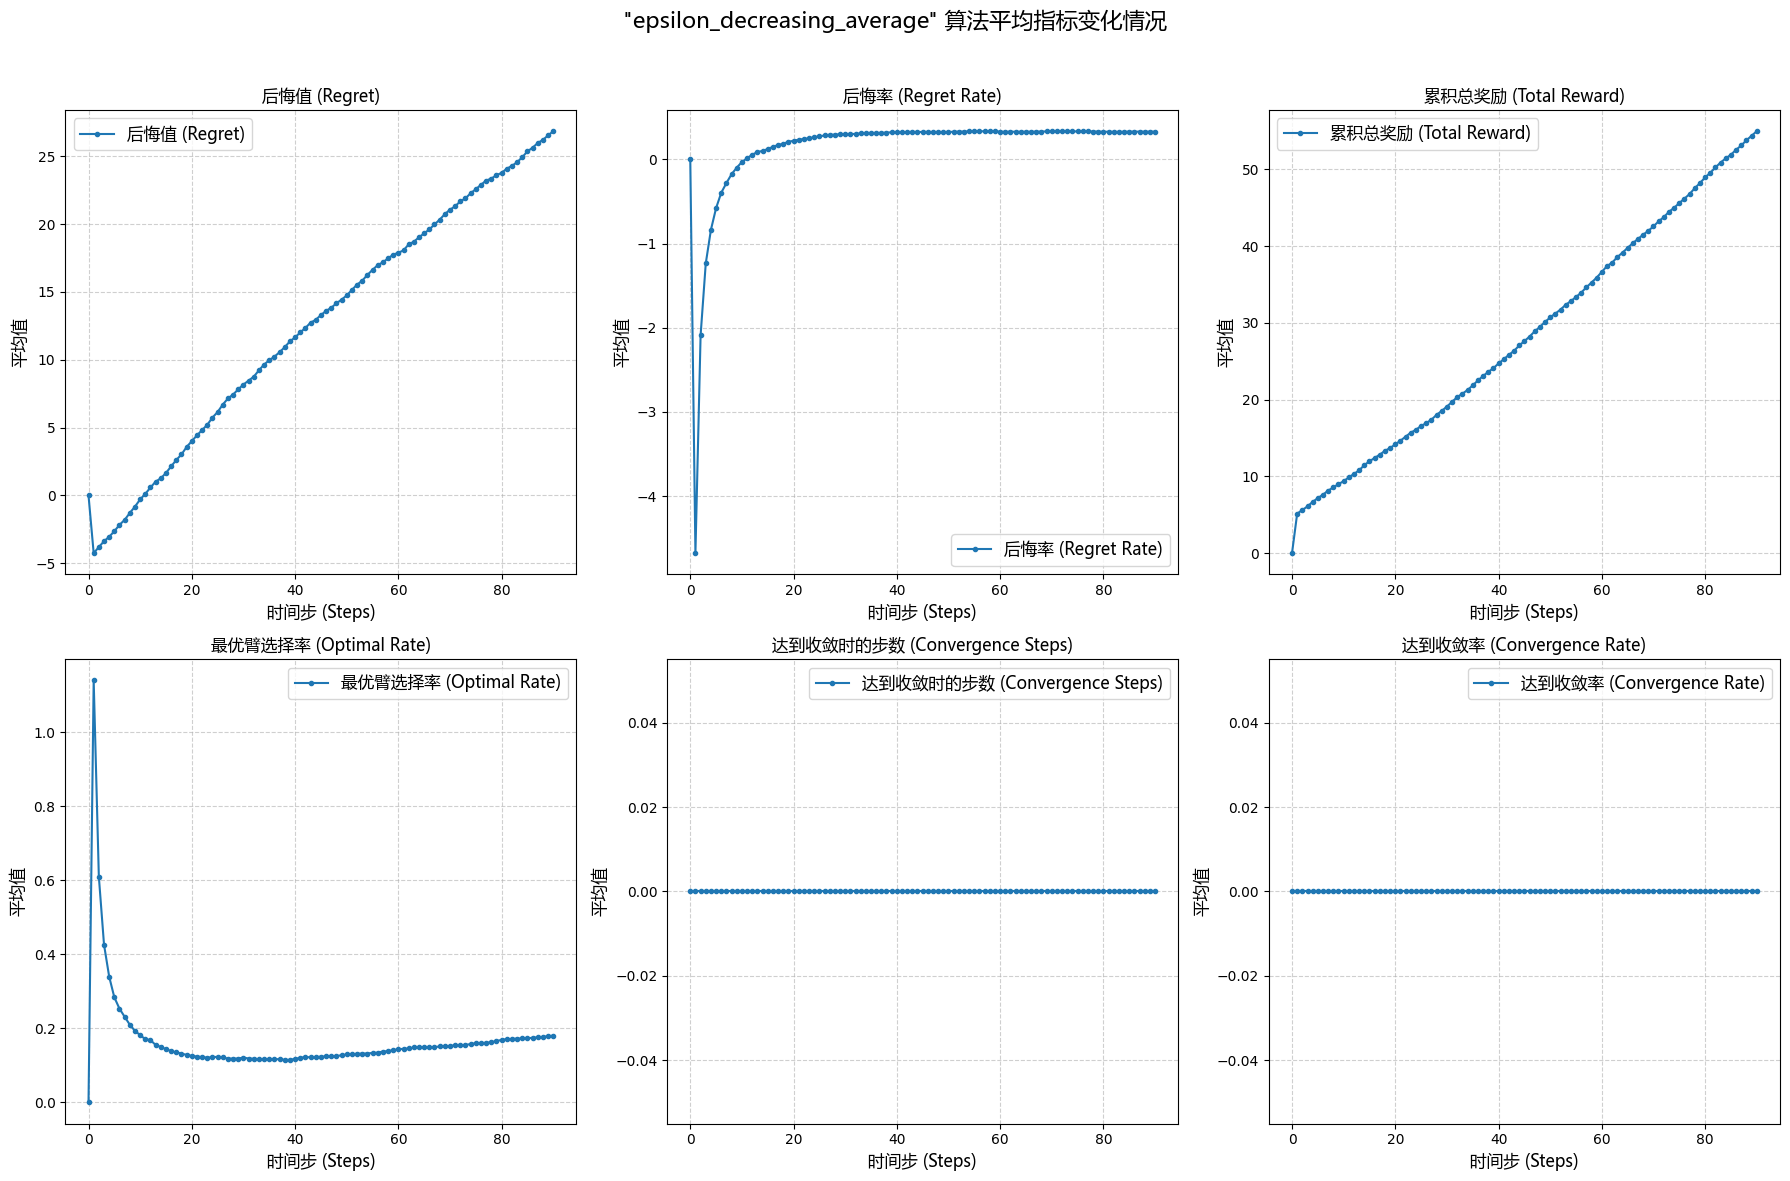

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_decreasing_average_T=100_K=10_Q_0=1.png
✅ 实验数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_decreasing_average_T=100_K=10_Q_0=1.json


20824

In [8]:
agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_decreasing_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    log_steps=LOG_INTERVAL,
)
print(metrics)
print(reward)

file_name: Path =EXPERIMENT_DATA_DIR / f"{epsilon_decreasing_average.__name__}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
plot_metrics_history(agents, epsilon_decreasing_average.__name__, file_name)
save_experiment_data(reward, metrics, file_name)

del agents, reward, metrics
gc.collect()

## UCB1算法

avg_regret=29.18909090909092 avg_regret_rate=0.32108000000000003 avg_total_reward=61.72 avg_optimal_rate=0.21300000000000005 avg_convergence_steps=0.0 avg_convergence_rate=0.0
values=[0.28, 0.68, 1.22, 1.86, 2.84, 4.82, 7.18, 10.74, 12.88, 19.22] counts=[4.4, 4.82, 5.38, 6.24, 7.2, 9.04, 11.2, 14.32, 16.1, 21.3]


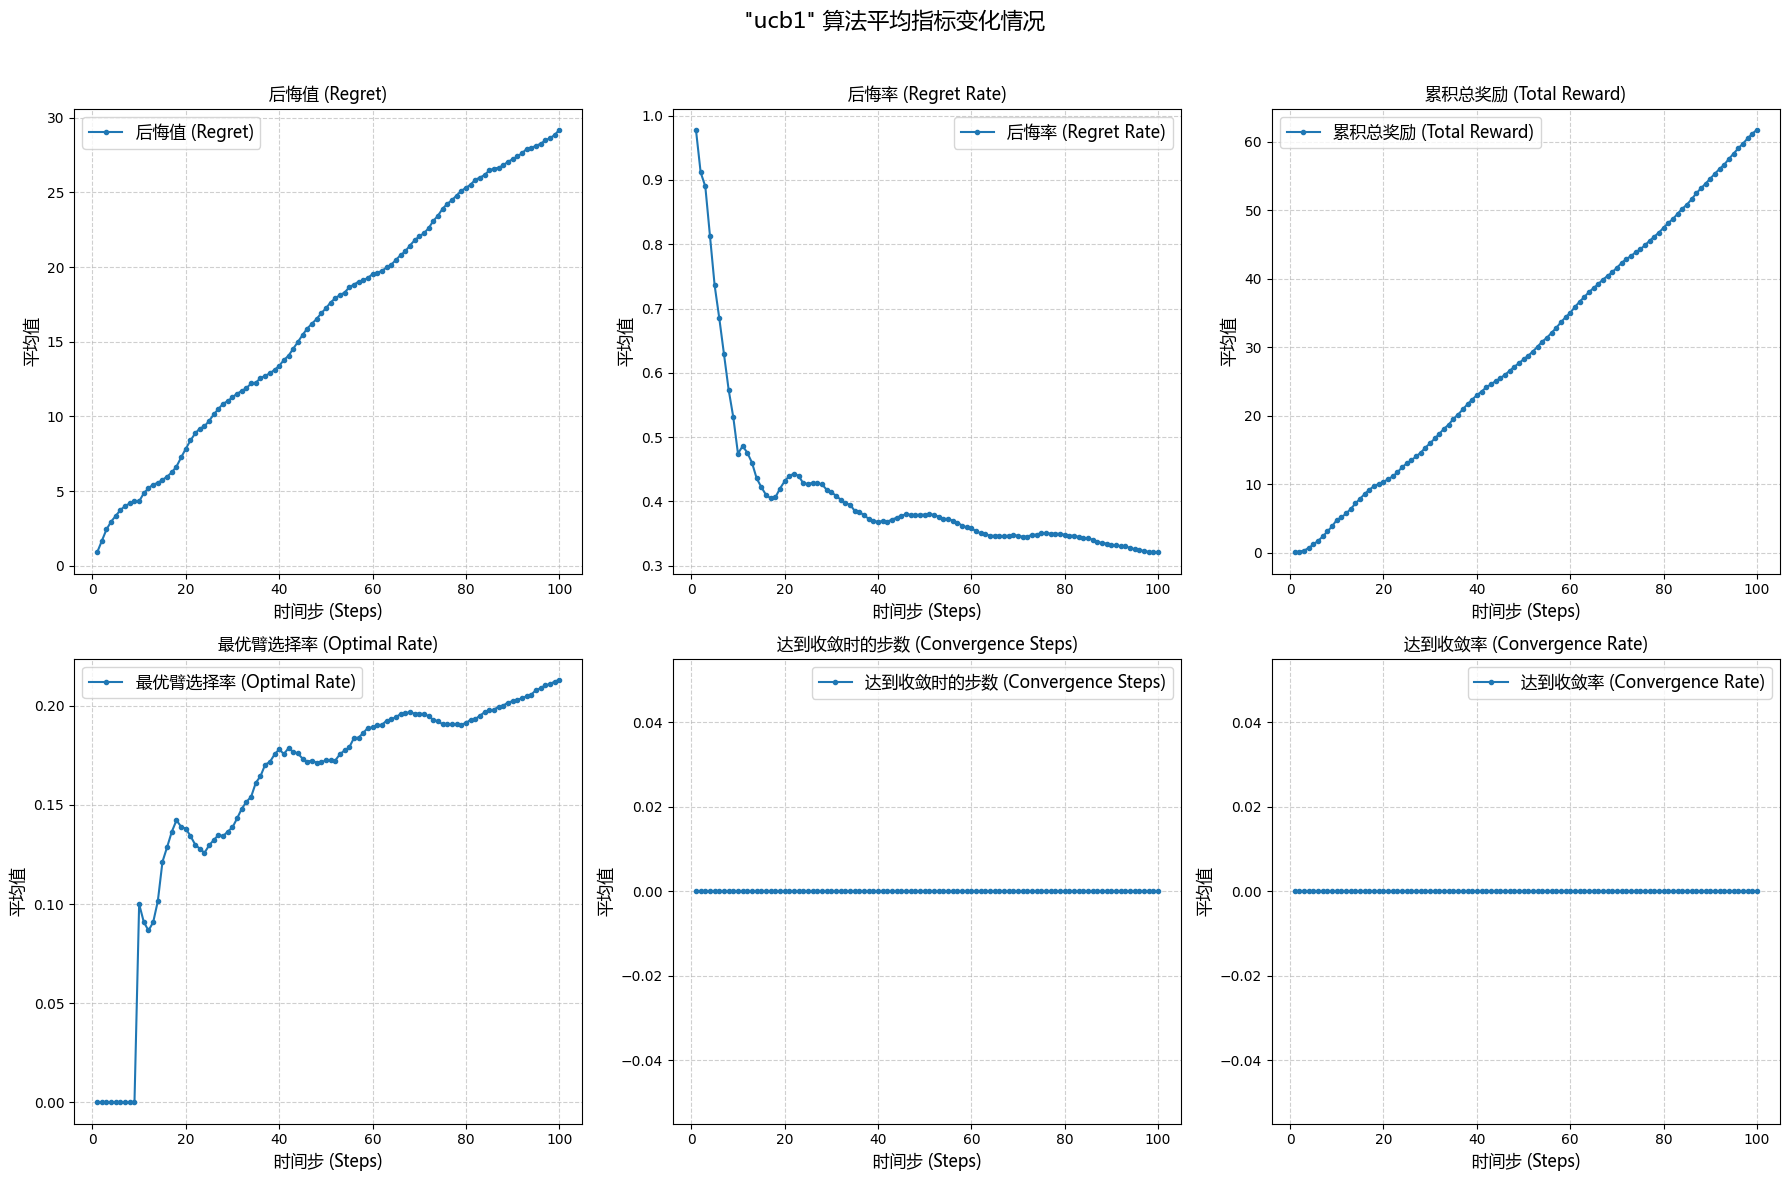

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb1_T=100_K=10.png
✅ 实验数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb1_T=100_K=10.json


22175

In [9]:
agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_ucb1_agent,
    env=ENV,
    steps=STEPS,
    seed=SEED,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    log_steps=LOG_INTERVAL,
)
print(metrics)
print(reward)

file_name: Path =EXPERIMENT_DATA_DIR / f"{ucb1.__name__}_T={STEPS}_K={MACHINE_COUNT}.png"
plot_metrics_history(agents, ucb1.__name__, file_name)
save_experiment_data(reward, metrics, file_name)

del agents, reward, metrics
gc.collect()